<a href="https://colab.research.google.com/github/vinay10949/AnalyticsAndML/blob/master/1_7Random_Sample_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Random sample imputation

Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a **complete dataset** that can then be then used for machine learning.

Random sampling imputation is in principle similar to mean / median / mode imputation, in the sense that it aims to preserve the statistical parameters of the original variable, for which data is missing.

Random sampling consist of taking a random observation from the pool of available observations of the variable, and using that randomly extracted value to fill the NA. In random sample imputation one takes as many random observations as missing values are present in the variable.

By random sampling observations of the variable for those instances where data is available, we guarantee that the mean and standard deviation of the variable are preserved.

By random sampling observations of the present categories, for categorical variables, we guarantee that the frequency of the different categories / labels within the variable is preserved.


### Which variables can I impute by Random Sample Imputation?

Random Sample Imputation can be applied to both numerical and categorical variables.


### Assumptions

Random sample imputation assumes that the data are missing completely at random (MCAR). If this is the case, it makes sense to substitute the missing values by values extracted from the original variable distribution. 

From a probabilistic point of view, values that are more frequent, like the mean or the median or the most frequent category, for categorical variables, will be selected more often -because there are more of them to select from-, but other less frequent values will be selected as well. Thus, the variance and distribution of the variable are preserved. 

The idea is to replace the population of missing values with a population of values with the same distribution of the original variable.


### Advantages

- Easy to implement
- Fast way of obtaining complete datasets
- Preserves the variance of the variable

### Limitations

- Randomness
- The relationship of imputed variables with other variables may be affected if there are a lot of NA
- Memory heavy for deployment, as we need to store the original training set to extract values from and replace the NA in coming observations.


### When to use Random Sample Imputation?

- Data is missing completely at random
- No more than 5% of the variable contains missing data
- Well suited for linear models as it does not distort the distribution, regardless of the % of NA

If used in combination with a Missing Indicator, as we will see in the next lecture, then this method can be used when data is not missing at random as well, or when there are many missing observations.


#### Randomness

Randomness may not seem much of a concern when replacing missing values for data competitions, where the whole batch of missing values is replaced once and then the dataset is scored and that is the end of the problem. However, in business scenarios the situation is very different. 

Imagine for example a car manufacturer is trying to predict how long a certain car will be in the garage before it passes all the security tests. Today, they receive a car with missing data in some of the variables, they run the machine learning model to predict how long this car will stay in the garage, the model replaces missing values by a random sample of the variable and then produces an estimate of time. Tomorrow, when they run the same model on the same car, the model will randomly assign values to the missing data, that may or may not be the same as the ones it selected today, therefore, the final estimation of time in the garage, may or may not be the same as the one obtained the day before.

In addition, imagine the car manufacturer evaluates 2 different cars that have exactly the same values for all of the variables, and missing values in exactly the same subset of variables. They run the machine learning model for each car, and because the missing data is randomly filled with values, the 2 cars, that are exactly the same, may end up with different estimates of time in the garage.

This may sound completely trivial and unimportant, however, businesses must follow a variety of regulations, and some of them require the same treatment to be provided to the same situation. So if instead of cars, these were people applying for a loan, or people seeking for disease treatment, the machine learning model would end up providing different solutions to candidates that are otherwise in the same conditions. And this is not fair or acceptable. This behaviour needs to be avoided.

#### So, should we randomly replace NA or not?

It is still possible to replace missing data by random sample, but these randomness needs to be controlled, so that individuals in the same situation end up with the same scores and therefore with the same solutions offered. How can we ensure this? by appropriately setting seeds during the random extraction of values.

Finally, another potential limitation of random sampling, similarly to replacing with the mean and median, is that estimates of covariance and correlations with other variables in the dataset may also be washed off by the randomness, particularly if there are a lot of missing observations.


### Final note

Replacement of missing values by random sample, although similar in concept to replacement by the median or mean, is not as widely used in the data science community as the mean / median imputation, presumably because of the element of randomness, or because the code implementation is not so straightforward.

However, it is a valid approach, with clear advantages over mean / median imputation as it preserves the distribution of the variable. And if you are mindful of the element of randomness and account for it somehow, this may as well be your method of choice, particularly for linear models.


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# to split and standarise the datasets
from sklearn.model_selection import train_test_split

## Random Sampling for Numerical Variables

In [97]:
# load the Titanic Dataset with a few variables for demonstration

data = pd.read_csv('titanic_train.csv', usecols=['Age', 'Fare', 'Survived'])
data.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [98]:
# let's look at the percentage of NA

data.isnull().mean()

Survived    0.000000
Age         0.198653
Fare        0.000000
dtype: float64

### Imputation important

Imputation should done over the training set, and then propagated to the test set. This means that the random sample to be used to fill missing values both in train and test set, should be extracted from the train set.

In [99]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data.Survived,
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 3), (268, 3))

In [100]:
# let's impute Age by random sampling both in
# train and test sets

# create the new variable where NA will be imputed:
# make a copy from the original variable, with NA
X_train['Age_imputed'] = X_train['Age'].copy()
X_test['Age_imputed'] = X_test['Age'].copy()

# extract the random sample to fill the na:
# remember we do this always from the train set, and we use
# these to fill both train and test

random_sample_train = X_train['Age'].dropna().sample(
    X_train['Age'].isnull().sum(), random_state=0)

random_sample_test = X_train['Age'].dropna().sample(
    X_test['Age'].isnull().sum(), random_state=0)

# what is all of the above code doing?

# 1) dropna() removes the NA from the original variable, this
# means that I will randomly extract existing values and not NAs

# 2) sample() is the method that will do the random sampling

# 3) X_train['Age'].isnull().sum() is the number of random values to extract
# I want to extract as many values as NAs are present in the original variable

# 4) random_state sets the seed for reproducibility, so that I extract 
# always the same random values, every time I run this notebook

# pandas needs to have the same index in order to merge datasets
random_sample_train.index = X_train[X_train['Age'].isnull()].index
random_sample_test.index = X_test[X_test['Age'].isnull()].index

# replace the NA in the newly created variable
X_train.loc[X_train['Age'].isnull(), 'Age_imputed'] = random_sample_train
X_test.loc[X_test['Age'].isnull(), 'Age_imputed'] = random_sample_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [101]:
# check that NA were imputed
X_train['Age_imputed'].isnull().sum()

0

In [102]:
# check that NA were imputed
X_test['Age_imputed'].isnull().sum()

0

In [103]:
X_train.head(15)

,Survived,Age,Fare,Age_imputed
857,1,51.0,26.5500,51.0
52,1,49.0,76.7292,49.0
386,0,1.0,46.9000,1.0
124,0,54.0,77.2875,54.0
578,0,NaN,14.4583,16.0
549,1,8.0,36.7500,8.0
118,0,24.0,247.5208,24.0
12,0,20.0,8.0500,20.0
157,0,30.0,8.0500,30.0
127,1,24.0,7.1417,24.0


We can see how NAs are replaced by different values in the different rows! This is what we wanted.

#### Random sampling preserves the original distribution of the variable

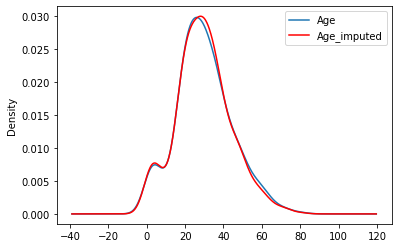

In [104]:
# we can see that the distribution of the variable after
# random sample imputation is almost exactly the same as the original

fig = plt.figure()
ax = fig.add_subplot(111)

X_train['Age'].plot(kind='kde', ax=ax)
X_train['Age_imputed'].plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

We can see that replacing missing values with a random sample from the training set preserves the original distribution of the variable. If you remember from previous notebooks, every other imputation technique altered the distribution of Age, because the percentage of NA in Age is high, ~20%. However, random sample imputation preserves the distribution, even in those cases. So this imputation technique is quite handy, if we are building linear models and we don't want to distort normal distributions.

In [105]:
# there is some change in the variance of the variable.
# however this change is much smaller compared to mean / median
# imputation (check the previous notebook for comparison)

print('Original variable variance: ', X_train['Age'].var())
print('Variance after random imputation: ', X_train['Age_imputed'].var())

Original variable variance:  210.45286924636747
Variance after random imputation:  201.59945157649167


In [106]:
# the covariance of Age with Fare is also less affected by this
# imputation technique compared to mean / median imputation

X_train[['Fare', 'Age', 'Age_imputed']].cov()

,Fare,Age,Age_imputed
Fare,2328.801583,78.468894,83.260641
Age,78.468894,210.452869,210.452869
Age_imputed,83.260641,210.452869,201.599452


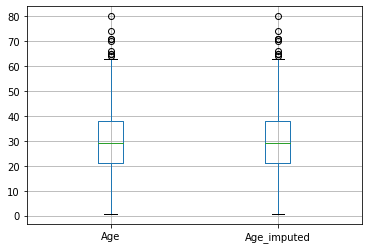

In [107]:
# Finally, the outliers are also less affected by this imputation
# technique

# Let's find out using a boxplot
X_train[['Age', 'Age_imputed']].boxplot()

So random sample imputation offers all the advantages provided by the preservation of the original distribution. And that is a big plus, particularly, if we care about distribution and outliers for our machine learning models. This is particularly relevant for linear models. But not so important for tree based algorithms.

## Randomness can lead to different scores being assigned to the same observation

Let's examine the effect of randomness on multiple scoring, and how we can mitigate this behaviour, as this is very important when putting our models in production / integrating our models with live systems.

In [108]:
# let's pick one observation with NA in Age
# in this case we pick observation indexed 5

observation = data[data.Age.isnull()].head(1)
observation

,Survived,Age,Fare
5,0,NaN,8.4583


In [140]:
# and now let's fill that NA with a random value
# extracted from the same variable where observations are available

# extract a random value, just 1
sampled_value = X_train['Age'].dropna().sample(1)

# re index to 5
sampled_value.index = [15]  # pandas needs the same index to be able to merge

# replace the NA with the sampled value
observation['Age_random'] = sampled_value

observation['Age_random']=sampled_value[15]
observation


,Survived,Age,Fare,Age_random
888,0,NaN,23.45,21.0


In [143]:
# let's repeat the exercise again: 
# we fill the NA with another random extracted value

# extract a random value, just 1
sampled_value = X_train['Age'].dropna().sample(1)

# re index to 5
sampled_value.index = [15]  #pandas needs the same index to be able to merge

# replace the NA with the sampled value
observation['Age_random'] = sampled_value[15]

observation

,Survived,Age,Fare,Age_random
888,0,NaN,23.45,31.0


In [144]:
# and again
# we fill the NA with another random extracted value

# extract a random value, just 1
sampled_value = X_train['Age'].dropna().sample(1)

# re index to 5
sampled_value.index = [15]  #pandas needs the same index to be able to merge

# replace the NA with the sampled value
observation['Age_random'] = sampled_value[15]

observation

,Survived,Age,Fare,Age_random
888,0,NaN,23.45,63.0


We can see that every time we repeat the operation, we get a different value replacement for exactly the same observation. In fact, if we repeat the process 1000 times:

Text(0, 0.5, 'Number of times')

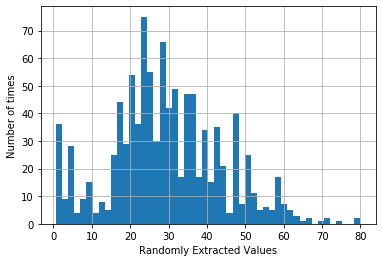

In [145]:
# if we repeat the process 1000 times:

values_ls = []

# capture the non-Na values to speed
# the computation
tmp = X_train.Age.dropna()

for i in range(1000):
    
    # extract a random value, just 1
    sampled_value = tmp.sample(1).values
    
    # add the extracted value to the list
    values_ls.append(float(sampled_value))
    
pd.Series(values_ls).hist(bins=50)
plt.xlabel('Randomly Extracted Values')
plt.ylabel('Number of times')

We obtain very different values for the same observation. Note how the distribution of extracted values is similar to the distribution of Age.

If this were patients looking for treatment, every time we run a predictive model, which would operate on the differently randomly extracted values, we would assign patients with the same characteristics to different treatments, and this is not OK.

### How can we fix this behaviour?

We can fix this randomness by assigning a seed:

In [148]:
values_ls = []

for i in range(100):

    # extract a random value, just 1, now with seed
    sampled_value = X_train.Age.dropna().sample(1, random_state=20)

    # add random value to the list
    values_ls.append(float(sampled_value))

# print the values
pd.Series(values_ls).unique()

array([30.5])

In [147]:
values_ls

[2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0]

Now that we set the seed, every randomly extracted value for that observation is the same.

However, if we set the same seed for every single observation, what would happen is that for every different observation, we would be filling the NA with exactly the same value (same seed == same random value extracted). This would be the equivalent to arbitrary value imputation!!!

We don't want that behaviour either.

Therefore, we want our seed to change observation per observation, but in a controlled manner, so that 2 observations that are exactly the same, receive the same imputed random values. But 2 observations that are different, receive different imputed random values.

### Controlling the element of randomness by varying the seed

We can attribute a different seed to each observation, and in fact, we can make this seed depend on an alternative variable of the same observation, thus, thinking in the Titanic dataset, if 2 passengers paid exactly the same Fare, they would get exactly the same probability of survival (when Age is missing).

In [149]:
# let's pick one observation with NA in Age
# in this case we pick observation indexed 5

observation = data[data.Age.isnull()].head(1)
observation

,Survived,Age,Fare
5,0,NaN,8.4583


In [163]:
# the seed is now the Fare

int(observation.Fare)

23

In [165]:
# we assign the Fare as the seed in the random sample extraction
sampled_value = X_train.Age.dropna().sample(1,
                                            random_state=int(observation.Fare))
sampled_value.index = [15]

observation['Age_random'] = sampled_value[15]
observation

,Survived,Age,Fare,Age_random
888,0,NaN,23.45,35.0


In [162]:
# for a different observation with a different Fare,
# we would get a different randomly extracted value

observation = data[data.Age.isnull()].tail(1)
observation

,Survived,Age,Fare
888,0,NaN,23.45


In [166]:
# new seed
int(observation.Fare)

23

In [169]:
# we assign the Fare as the seed in the random sample extraction
sampled_value = X_train.Age.dropna().sample(1,
                                            random_state=int(observation.Fare))
sampled_value.index = [1305]

observation['Age_random'] = sampled_value[1305]
observation

,Survived,Age,Fare,Age_random
888,0,NaN,23.45,35.0


This is a way of controlling the randomness. Using the Fare to set the random state, you guarantee that for 2 passengers with equal Fare, the Age will be replaced with the same number, and therefore the 2 passengers will get the same probability of survival.

### Note!!

In real life, you will build models that use tens of variables or more. So in cases like those, you can think of picking the 3-5 more important variables, those that have the strongest impact on the output of the machine learning model, and combine them to create the random state. Therefore, customers that share the 3-5 main variable values, will get the same scores.

## Random Sampling for Categorical Variables

In [170]:
# let's load the dataset with a few columns for the demonstration
cols_to_use = ['BsmtQual', 'FireplaceQu', 'SalePrice']

data = pd.read_csv('houseprice_train.csv', usecols=cols_to_use)

# let's inspect the percentage of missing values in each variable
data.isnull().mean().sort_values(ascending=True)

SalePrice      0.000000
BsmtQual       0.025342
FireplaceQu    0.472603
dtype: float64

In [171]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data.SalePrice,
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 3), (438, 3))

In [174]:
# let's impute BsmtQual by random sampling both in
# train and test sets

# create the new variable where NA will be imputed
# make a copy from the original variable, with NA
X_train['BsmtQual_imputed'] = X_train['BsmtQual'].copy()
X_test['BsmtQual_imputed'] = X_test['BsmtQual'].copy()

# extract the random sample to fill the na:
# remember we do this always from the train set, and we use
# these to fill both train and test

random_sample_train = X_train['BsmtQual'].dropna().sample(
    X_train['BsmtQual'].isnull().sum(), random_state=0)

random_sample_test = X_train['BsmtQual'].dropna().sample(
    X_test['BsmtQual'].isnull().sum(), random_state=0)

# what is all of the above code doing?
# 1) dropna() removes the NA from the original variable, this
# means that I will randomly extract existing values and not NAs

# 2) sample() is the method that will do the random sampling

# 3) X_train['BsmtQual'].isnull().sum() is the number of random values to extract
# I want to extract as many values as NAs are present in the original variable

# 4) random_state sets the seed for reproducibility, so that I extract 
# always the same random values, every time I run this notebook

# pandas needs to have the same index in order to merge datasets
random_sample_train.index = X_train[X_train['BsmtQual'].isnull()].index
random_sample_test.index = X_test[X_test['BsmtQual'].isnull()].index

# replace the NA in the newly created variable
X_train.loc[X_train['BsmtQual'].isnull(), 'BsmtQual_imputed'] = random_sample_train
X_test.loc[X_test['BsmtQual'].isnull(), 'BsmtQual_imputed'] = random_sample_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [173]:
# let's impute FireplaceQu by random sampling both in
# train and test sets

# create the new variable where NA will be imputed
# make a copy from the original variable, with NA
X_train['FireplaceQu_imputed'] = X_train['FireplaceQu'].copy()
X_test['FireplaceQu_imputed'] = X_test['FireplaceQu'].copy()

# extract the random sample to fill the na:
# remember we do this always from the train set, and we use
# these to fill both train and test

random_sample_train = X_train['FireplaceQu'].dropna().sample(
    X_train['FireplaceQu'].isnull().sum(), random_state=0)

random_sample_test = X_train['FireplaceQu'].dropna().sample(
    X_test['FireplaceQu'].isnull().sum(), random_state=0)

# what is all of the above code doing?
# 1) dropna() removes the NA from the original variable, this
# means that I will randomly extract existing values and not NAs

# 2) sample() is the method that will do the random sampling

# 3) X_train['FireplaceQu'].isnull().sum() is the number of random values to extract
# I want to extract as many values as NAs are present in the original variable

# 4) random_state sets the seed for reproducibility, so that I extract 
# always the same random values, every time I run this notebook

# pandas needs to have the same index in order to merge datasets
random_sample_train.index = X_train[X_train['FireplaceQu'].isnull()].index
random_sample_test.index = X_test[X_test['FireplaceQu'].isnull()].index

# replace the NA in the newly created variable
X_train.loc[X_train['FireplaceQu'].isnull(), 'FireplaceQu_imputed'] = random_sample_train
X_test.loc[X_test['FireplaceQu'].isnull(), 'FireplaceQu_imputed'] = random_sample_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [175]:
# check that nulls were removed
X_train['FireplaceQu_imputed'].isnull().sum()

0

In [0]:
# and now let's evaluate the effect of the imputation on the distribution
# of the categories and the target within those categories

# we used a similar function in the notebook of arbitrary value imputation
# for categorical variables

def categorical_distribution(df, variable_original, variable_imputed):

    tmp = pd.concat(
        [
            # percentage of observations per category, original variable
            df[variable_original].value_counts() / len(df[variable_original].dropna()),

            # percentage of observations per category, imputed variable
            df[variable_imputed].value_counts() / len(df)
        ],
        axis=1)

    # add column names
    tmp.columns = ['original', 'imputed']

    return tmp

In [177]:
# run the function in a categorical variable
categorical_distribution(X_train, 'BsmtQual', 'BsmtQual_imputed')

,original,imputed
TA,0.463928,0.465753
Gd,0.430862,0.428571
Ex,0.082164,0.083170
Fa,0.023046,0.022505


In [178]:
# run the function in a categorical variable
categorical_distribution(X_train, 'FireplaceQu', 'FireplaceQu_imputed')

,original,imputed
Gd,0.468750,0.469667
TA,0.420956,0.420744
Fa,0.047794,0.046967
Ex,0.033088,0.032290
Po,0.029412,0.030333


As expected, the percentage of observations within each category is very similar in the original and imputed variables, for both BsmtQual where NA are low and FireplaceQu were NA are high.

In [0]:
# now let's look at the distribution of the target within each
# variable category

def automate_plot(df, variable, target):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for category in df[variable].dropna().unique():
        df[df[variable]==category][target].plot(kind='kde', ax=ax)
    
    # add the legend
    lines, labels = ax.get_legend_handles_labels()
    labels = df[variable].dropna().unique()
    ax.legend(lines, labels, loc='best')
    
    plt.show()

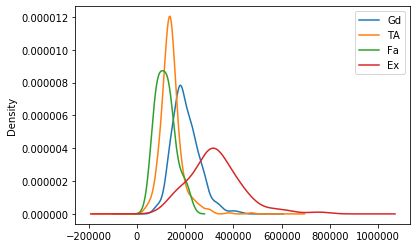

In [180]:
automate_plot(X_train, 'BsmtQual', 'SalePrice')

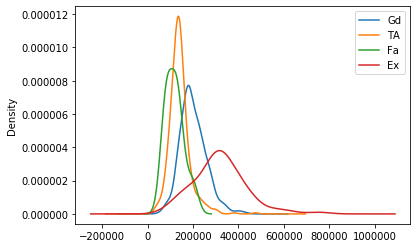

In [181]:
automate_plot(X_train, 'BsmtQual_imputed', 'SalePrice')

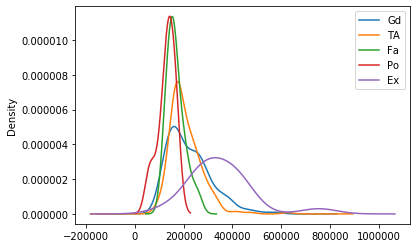

In [182]:
automate_plot(X_train, 'FireplaceQu', 'SalePrice')

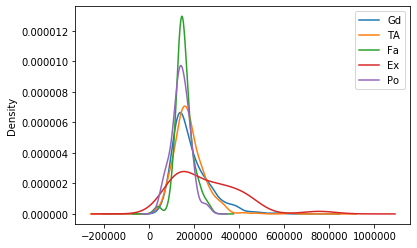

In [183]:
automate_plot(X_train, 'FireplaceQu_imputed', 'SalePrice')

For BsmtQual, where the NA are low, the distribution of the target is preserved for the categories in the original and imputed variable. However, for FireplaceQu, which contains more NAs, the distribution of the target per category is affected slightly.
